# Model Comparison Lab

In this lab we will compare the performance of all the models we have learned about so far, using the car evaluation dataset.

## 1. Prepare the data

The [car evaluation dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/car/) is in the assets/datasets folder. By now you should be very familiar with this dataset.

1. Load the data into a pandas dataframe
- Encode the categorical features properly: define a map that preserves the scale (assigning smaller numbers to words indicating smaller quantities)
- Separate features from target into X and y

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
%matplotlib inline

In [2]:
df = pd.read_csv('./../../assets/datasets/car.csv')
df.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [3]:
df['safety'].value_counts()

med     576
high    576
low     576
Name: safety, dtype: int64

In [4]:
map_maint = {'vhigh': 4,
       'high': 3,
       'med': 2,
       'low':1}
map_doors = {'5more': 4,
       '4': 3,
       '3': 2,
       '2':1}
map_persons = {'more': 3,
       '4': 2,
       '2':1}
map_lug_boot = {'big': 3,
       'med': 2,
       'small':1}
map_safety = {'high': 3,
       'med': 2,
       'low':1}


# def thing(i):return map_maint[i]
X_ = pd.DataFrame()
X_['maint'] = map(lambda(x):map_maint[x], df['maint'])
X_['buying'] = map(lambda(x):map_maint[x], df['buying'])
X_['doors'] = map(lambda(x):map_doors[x], df['doors'])
X_['persons'] = map(lambda(x):map_persons[x], df['persons'])
X_['lug_boot'] = map(lambda(x):map_lug_boot[x], df['lug_boot'])
X_['safety'] = map(lambda(x):map_safety[x], df['safety'])
X = X_
X.head()

,maint,buying,doors,persons,lug_boot,safety
0,4,4,1,1,1,1
1,4,4,1,1,1,2
2,4,4,1,1,1,3
3,4,4,1,1,2,1
4,4,4,1,1,2,2


In [5]:
X_ = pd.get_dummies(df.drop('acceptability', axis=1))
le = LabelEncoder()
y = le.fit_transform(df['acceptability'])

X.head()

,maint,buying,doors,persons,lug_boot,safety
0,4,4,1,1,1,1
1,4,4,1,1,1,2
2,4,4,1,1,1,3
3,4,4,1,1,2,1
4,4,4,1,1,2,2


## 2. Useful preparation

Since we will compare several models, let's write a couple of helper functions.

1. Separate X and y between a train and test set, using 30% test set, random state = 42
    - make sure that the data is shuffled and stratified
2. Define a function called `evaluate_model`, that trains the model on the train set, tests it on the test, calculates:
    - accuracy score
    - confusion matrix
    - classification report
3. Initialize a global dictionary to store the various models for later retrieval


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

In [7]:
def evaluate_model(model):
    # create model object
    mod = model
    # fit model
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    print 'Accuracy score:', mod.score(X_test, y_test)
    con = pd.DataFrame(confusion_matrix(y_pred, y_test))
    con.columns = ['acc', 'good', 'unacc', 'vgood']
    con.index = ['pred_acc', 'pred_good', 'pred_unacc', 'pred_vgood']
    print con
    print classification_report(y_pred, y_test)
    return mod

models = {}

## 3.a KNN

Let's start with `KNeighborsClassifier`.

1. Initialize a KNN model
- Evaluate it's performance with the function you previously defined
- Find the optimal value of K using grid search
    - Be careful on how you perform the cross validation in the grid search

In [8]:
models['KNN'] = evaluate_model(KNeighborsClassifier())

Accuracy score: 0.940455341506
            acc  good  unacc  vgood
pred_acc    114     5      9      3
pred_good     1    17      0      3
pred_unacc   12     1    391      0
pred_vgood    0     0      0     15
             precision    recall  f1-score   support

          0       0.90      0.87      0.88       131
          1       0.74      0.81      0.77        21
          2       0.98      0.97      0.97       404
          3       0.71      1.00      0.83        15

avg / total       0.94      0.94      0.94       571



In [9]:
pg = {'n_neighbors': [i for i in range(1,20)]}
gs = GridSearchCV(models['KNN'], param_grid=pg, cv=5)
gs.fit(X_train, y_train)
gs.best_params_

{'n_neighbors': 5}

## 3.b Bagging + KNN

Now that we have found the optimal K, let's wrap `KNeighborsClassifier` in a BaggingClassifier and see if the score improves.

1. Wrap the KNN model in a Bagging Classifier
- Evaluate performance
- Do a grid search only on the bagging classifier params

In [10]:
models['bagging_knn'] = evaluate_model(BaggingClassifier(models['KNN'].set_params(n_neighbors=5)))

Accuracy score: 0.92819614711
            acc  good  unacc  vgood
pred_acc    109     4     11      3
pred_good     0    16      0      2
pred_unacc   18     3    389      0
pred_vgood    0     0      0     16
             precision    recall  f1-score   support

          0       0.86      0.86      0.86       127
          1       0.70      0.89      0.78        18
          2       0.97      0.95      0.96       410
          3       0.76      1.00      0.86        16

avg / total       0.93      0.93      0.93       571



In [11]:
pg = {'n_estimators': [4, 8, 10, 12, 15],
     'bootstrap': [True, False],
     'bootstrap_features': [True, False]}
def grid_search(model, pg):
    gs = GridSearchCV(model, param_grid=pg, cv=3)
    gs.fit(X_train, y_train)
    print gs.best_params_
grid_search(models['bagging_knn'], pg)

{'n_estimators': 10, 'bootstrap': True, 'bootstrap_features': False}


In [12]:
evaluate_model(models['bagging_knn'].set_params(bootstrap=True, bootstrap_features=False, n_estimators=15))

Accuracy score: 0.935201401051
            acc  good  unacc  vgood
pred_acc    111     6      9      2
pred_good     0    15      0      2
pred_unacc   16     2    391      0
pred_vgood    0     0      0     17
             precision    recall  f1-score   support

          0       0.87      0.87      0.87       128
          1       0.65      0.88      0.75        17
          2       0.98      0.96      0.97       409
          3       0.81      1.00      0.89        17

avg / total       0.94      0.94      0.94       571



BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=15, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

## 4. Logistic Regression

Let's see if logistic regression performs better

1. Initialize LR and test on Train/Test set
- Find optimal params with Grid Search
- See if Bagging improves the score

In [13]:
models['logreg'] = evaluate_model(LogisticRegression())

Accuracy score: 0.782837127846
            acc  good  unacc  vgood
pred_acc     55    12     11     17
pred_good     2     3      0      0
pred_unacc   70     4    385      0
pred_vgood    0     4      4      4
             precision    recall  f1-score   support

          0       0.43      0.58      0.50        95
          1       0.13      0.60      0.21         5
          2       0.96      0.84      0.90       459
          3       0.19      0.33      0.24        12

avg / total       0.85      0.78      0.81       571



In [14]:
pg = {
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
}
grid_search(models['logreg'], pg)

{'penalty': 'l1', 'C': 10.0}


In [15]:
models['bagging_logreg'] = evaluate_model(BaggingClassifier(models['logreg'].set_params(penalty='l1', C=100.0)))

Accuracy score: 0.814360770578
            acc  good  unacc  vgood
pred_acc     61    10     14      6
pred_good     2     7      0      0
pred_unacc   62     5    382      0
pred_vgood    2     1      4     15
             precision    recall  f1-score   support

          0       0.48      0.67      0.56        91
          1       0.30      0.78      0.44         9
          2       0.95      0.85      0.90       449
          3       0.71      0.68      0.70        22

avg / total       0.86      0.81      0.83       571



In [16]:
pg = {'n_estimators': [4, 8, 10, 12, 15],
     'bootstrap': [True, False],
     'bootstrap_features': [True, False]}
grid_search(models['bagging_logreg'], pg)

{'n_estimators': 15, 'bootstrap': True, 'bootstrap_features': False}


In [17]:
evaluate_model(models['bagging_logreg'].set_params(n_estimators=10, bootstrap=True, bootstrap_features=False))

Accuracy score: 0.817863397548
            acc  good  unacc  vgood
pred_acc     60    10     12      7
pred_good     2     8      1      0
pred_unacc   64     5    385      0
pred_vgood    1     0      2     14
             precision    recall  f1-score   support

          0       0.47      0.67      0.56        89
          1       0.35      0.73      0.47        11
          2       0.96      0.85      0.90       454
          3       0.67      0.82      0.74        17

avg / total       0.87      0.82      0.83       571



BaggingClassifier(base_estimator=LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

## 5. Decision Trees

Let's see if Decision Trees perform better

1. Initialize DT and test on Train/Test set
- Find optimal params with Grid Search
- See if Bagging improves the score

In [18]:
models['dec_tree'] = evaluate_model(DecisionTreeClassifier())

Accuracy score: 0.973730297723
            acc  good  unacc  vgood
pred_acc    122     1      8      1
pred_good     1    22      0      0
pred_unacc    4     0    392      0
pred_vgood    0     0      0     20
             precision    recall  f1-score   support

          0       0.96      0.92      0.94       132
          1       0.96      0.96      0.96        23
          2       0.98      0.99      0.98       396
          3       0.95      1.00      0.98        20

avg / total       0.97      0.97      0.97       571



In [19]:
pg = {
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 1, 2, 3],
    'max_depth': [None, 4, 5, 6, 7, 8, 9],
    'max_leaf_nodes': [None, 4, 5, 6, 7, 8, 9]
}
grid_search(models['dec_tree'], pg)

{'max_features': None, 'max_leaf_nodes': None, 'criterion': 'gini', 'max_depth': None}


In [20]:
models['dec_tree'] = evaluate_model(models['dec_tree'].set_params(criterion='entropy'))

Accuracy score: 0.978984238179
            acc  good  unacc  vgood
pred_acc    124     1      5      2
pred_good     0    22      0      1
pred_unacc    3     0    395      0
pred_vgood    0     0      0     18
             precision    recall  f1-score   support

          0       0.98      0.94      0.96       132
          1       0.96      0.96      0.96        23
          2       0.99      0.99      0.99       398
          3       0.86      1.00      0.92        18

avg / total       0.98      0.98      0.98       571



In [21]:
models['bagging_dec_tree'] = evaluate_model(BaggingClassifier(models['dec_tree']))

Accuracy score: 0.971978984238
            acc  good  unacc  vgood
pred_acc    123     2      7      1
pred_good     1    21      0      2
pred_unacc    3     0    393      0
pred_vgood    0     0      0     18
             precision    recall  f1-score   support

          0       0.97      0.92      0.95       133
          1       0.91      0.88      0.89        24
          2       0.98      0.99      0.99       396
          3       0.86      1.00      0.92        18

avg / total       0.97      0.97      0.97       571



In [22]:
pg = {'n_estimators': [4, 8, 10, 12, 15],
     'bootstrap': [True, False],
     'bootstrap_features': [True, False]}
grid_search(models['bagging_dec_tree'], pg)

{'n_estimators': 12, 'bootstrap': True, 'bootstrap_features': False}


In [23]:
models['bagging_dec_tree'] = evaluate_model(BaggingClassifier(models['dec_tree'], n_estimators=4, 
                                                              bootstrap=False, bootstrap_features=False))

Accuracy score: 0.978984238179
            acc  good  unacc  vgood
pred_acc    124     1      5      2
pred_good     0    22      0      1
pred_unacc    3     0    395      0
pred_vgood    0     0      0     18
             precision    recall  f1-score   support

          0       0.98      0.94      0.96       132
          1       0.96      0.96      0.96        23
          2       0.99      0.99      0.99       398
          3       0.86      1.00      0.92        18

avg / total       0.98      0.98      0.98       571



## 6. Support Vector Machines

Let's see if SVM perform better

1. Initialize SVM and test on Train/Test set
- Find optimal params with Grid Search
- See if Bagging improves the score

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, stratify=y, test_size=0.33, random_state=42)

In [25]:
models['svc'] = evaluate_model(SVC())

Accuracy score: 0.903677758319
            acc  good  unacc  vgood
pred_acc    124    22     17     12
pred_good     0     0      0      0
pred_unacc    3     0    383      0
pred_vgood    0     1      0      9
             precision    recall  f1-score   support

          0       0.98      0.71      0.82       175
          1       0.00      0.00      0.00         0
          2       0.96      0.99      0.97       386
          3       0.43      0.90      0.58        10

avg / total       0.95      0.90      0.92       571



//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [26]:
pg = {
    'C': [1.0, 10.0, 100.0, 1000.0, 10000.0],
    'kernel': ['rbf', 'linear', 'poly'],
    'degree': [1, 2, 3, 4, 5]
}
grid_search(models['svc'], pg)

{'kernel': 'poly', 'C': 1000.0, 'degree': 3}


In [27]:
models['svc'] = evaluate_model(SVC(kernel='poly', C=1000.0, degree=3))

Accuracy score: 0.998248686515
            acc  good  unacc  vgood
pred_acc    127     1      0      0
pred_good     0    22      0      0
pred_unacc    0     0    400      0
pred_vgood    0     0      0     21
             precision    recall  f1-score   support

          0       1.00      0.99      1.00       128
          1       0.96      1.00      0.98        22
          2       1.00      1.00      1.00       400
          3       1.00      1.00      1.00        21

avg / total       1.00      1.00      1.00       571



In [28]:
models['bagging_svc'] = evaluate_model(BaggingClassifier(models['svc']))

Accuracy score: 0.991243432574
            acc  good  unacc  vgood
pred_acc    127     1      3      0
pred_good     0    22      0      1
pred_unacc    0     0    397      0
pred_vgood    0     0      0     20
             precision    recall  f1-score   support

          0       1.00      0.97      0.98       131
          1       0.96      0.96      0.96        23
          2       0.99      1.00      1.00       397
          3       0.95      1.00      0.98        20

avg / total       0.99      0.99      0.99       571



In [29]:
pg = {'n_estimators': [4, 8, 10, 12, 15],
     'bootstrap': [True, False],
     'bootstrap_features': [True, False]}
grid_search(models['bagging_svc'], pg)

{'n_estimators': 15, 'bootstrap': True, 'bootstrap_features': False}


In [30]:
models['bagging_svc'] = evaluate_model(BaggingClassifier(models['svc'], n_estimators=4, 
                                                              bootstrap=False, bootstrap_features=False))

Accuracy score: 0.998248686515
            acc  good  unacc  vgood
pred_acc    127     1      0      0
pred_good     0    22      0      0
pred_unacc    0     0    400      0
pred_vgood    0     0      0     21
             precision    recall  f1-score   support

          0       1.00      0.99      1.00       128
          1       0.96      1.00      0.98        22
          2       1.00      1.00      1.00       400
          3       1.00      1.00      1.00        21

avg / total       1.00      1.00      1.00       571



## 7. Random Forest & Extra Trees

Let's see if Random Forest and Extra Trees perform better

1. Initialize RF and ET and test on Train/Test set
- Find optimal params with Grid Search

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

In [32]:
models['rand_for'] = evaluate_model(RandomForestClassifier())

Accuracy score: 0.963222416813
            acc  good  unacc  vgood
pred_acc    121     4      7      2
pred_good     1    19      0      2
pred_unacc    5     0    393      0
pred_vgood    0     0      0     17
             precision    recall  f1-score   support

          0       0.95      0.90      0.93       134
          1       0.83      0.86      0.84        22
          2       0.98      0.99      0.98       398
          3       0.81      1.00      0.89        17

avg / total       0.96      0.96      0.96       571



In [33]:
pg = {
    'bootstrap': [True, False],
    'criterion':['gini', 'entropy'],
    'max_depth': [None, 3, 5, 7, 9, 15]
}
grid_search(models['rand_for'], pg)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 15}


In [34]:
models['rand_for'] = evaluate_model(RandomForestClassifier(bootstrap=False, criterion='entropy'))

Accuracy score: 0.973730297723
            acc  good  unacc  vgood
pred_acc    122     1      7      1
pred_good     0    22      0      1
pred_unacc    5     0    393      0
pred_vgood    0     0      0     19
             precision    recall  f1-score   support

          0       0.96      0.93      0.95       131
          1       0.96      0.96      0.96        23
          2       0.98      0.99      0.98       398
          3       0.90      1.00      0.95        19

avg / total       0.97      0.97      0.97       571



In [35]:
models['et'] = evaluate_model(ExtraTreesClassifier())

Accuracy score: 0.950963222417
            acc  good  unacc  vgood
pred_acc    120     5     13      1
pred_good     1    18      0      2
pred_unacc    6     0    387      0
pred_vgood    0     0      0     18
             precision    recall  f1-score   support

          0       0.94      0.86      0.90       139
          1       0.78      0.86      0.82        21
          2       0.97      0.98      0.98       393
          3       0.86      1.00      0.92        18

avg / total       0.95      0.95      0.95       571



In [36]:
pg = {
    'bootstrap': [True, False],
    'criterion':['gini', 'entropy'],
    'max_depth': [None, 3, 5, 7, 9, 15]
}
grid_search(models['et'], pg)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': None}


In [37]:
models['et'] = evaluate_model(ExtraTreesClassifier(bootstrap=False, criterion='entropy', max_depth=15))

Accuracy score: 0.973730297723
            acc  good  unacc  vgood
pred_acc    124     4      7      0
pred_good     1    19      0      1
pred_unacc    2     0    393      0
pred_vgood    0     0      0     20
             precision    recall  f1-score   support

          0       0.98      0.92      0.95       135
          1       0.83      0.90      0.86        21
          2       0.98      0.99      0.99       395
          3       0.95      1.00      0.98        20

avg / total       0.97      0.97      0.97       571



## 8. Model comparison

Let's compare the scores of the various models.

1. Do a bar chart of the scores of the best models. Who's the winner on the train/test split?
- Re-test all the models using a 3 fold stratified shuffled cross validation
- Do a bar chart with errorbars of the cross validation average scores. is the winner the same?


In [66]:
scores = []
mods = []
for i in models:
    if 'svc' not in i:
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
        scores.append(models[i].score(X_test, y_test))
        mods.append(i)
for i in models:
    if 'svc' in i:
        X_train, X_test, y_train, y_test = train_test_split(X_, y, stratify=y, test_size=0.33, random_state=42)
        scores.append(models[i].score(X_test, y_test))
        mods.append(i)
mod_scores = pd.DataFrame()
mod_scores['scores'] = scores
mod_scores['models'] = mods


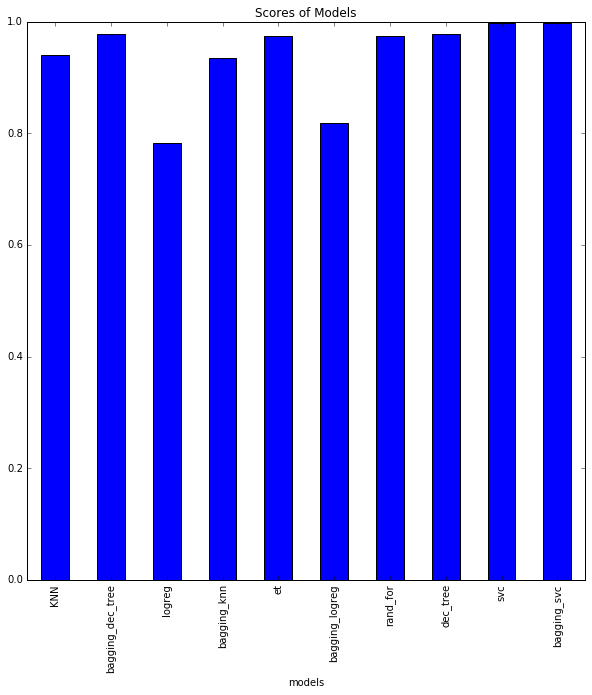

In [76]:
mod_scores.plot(x='models', y='scores', kind='bar', legend=False, title='Scores of Models', figsize=(10,10))
plt.show()

In [70]:
scores_ = []
mods_ = []
mean = []
std = []

for i in models:
    if 'svc' not in i:
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
        scores_.append(cross_val_score(models[i],X_test, y_test))
        mods_.append(i)
        mean.append(np.mean(cross_val_score(models[i],X_test, y_test)))
        std.append(np.std(cross_val_score(models[i],X_test, y_test)))
for i in models:
    if 'svc' in i:
        X_train, X_test, y_train, y_test = train_test_split(X_, y, stratify=y, test_size=0.33, random_state=42)
        scores_.append(cross_val_score(models[i],X_test, y_test))
        mods_.append(i)
        mean.append(np.mean(cross_val_score(models[i],X_test, y_test)))
        std.append(np.std(cross_val_score(models[i],X_test, y_test)))

mod_cvscores = pd.DataFrame()
mod_cvscores['scores'] = scores_
mod_cvscores['models'] = mods_
mod_cvscores['mean'] = mean
mod_cvscores['std'] = std
mod_cvscores.head()

,scores,models,mean,std
0,"[0.859375, 0.868421052632, 0.925925925926]",KNN,0.884574,0.029473
1,"[0.927083333333, 0.894736842105, 0.962962962963]",bagging_dec_tree,0.931761,0.030146
2,"[0.828125, 0.805263157895, 0.798941798942]",logreg,0.810777,0.012536
3,"[0.890625, 0.894736842105, 0.920634920635]",bagging_knn,0.900245,0.024421
4,"[0.942708333333, 0.905263157895, 0.920634920635]",et,0.921188,0.017886


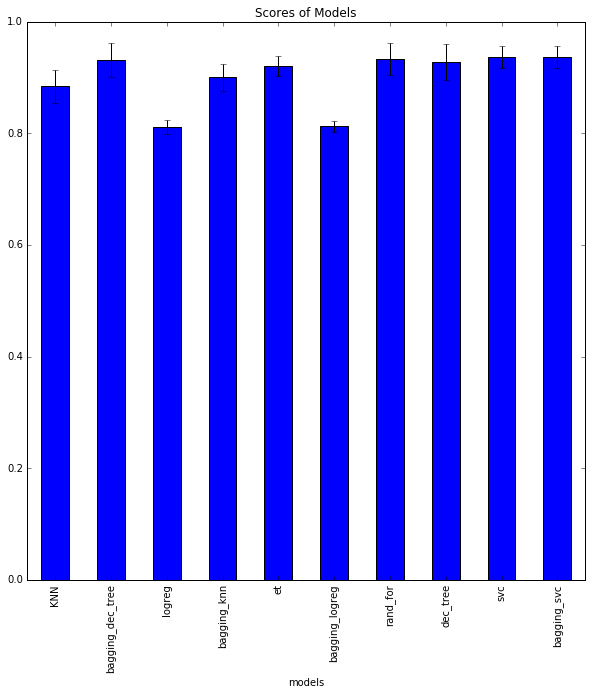

In [74]:
mod_cvscores.plot(x='models', y='mean', kind='bar', legend=False, 
                  title='Scores of Models', yerr='std', figsize=(10,10))
plt.show()

It looks like bagging_svc is still the best, but it's much closer.

## Bonus

We have encoded the data using a map that preserves the scale.
Would our results have changed if we had encoded the categorical data using `pd.get_dummies` or `OneHotEncoder`  to encode them as binary variables instead?

1. Repeat the analysis for this scenario. Is it better?
- Experiment with other models or other parameters, can you beat your classmates best score?